In [1]:
import pandas as pd
import re
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Activation, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from keras.models import load_model

In [2]:
df= pd.read_csv('train_preprocess.tsv.txt',sep='\t', header=None)

In [3]:
df.head()

,0,1
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [4]:
#Rename the column
df.rename(columns = {0:'text', 1:'labels' }, inplace = True)

In [5]:
#make function to clean text and make a new "clean_text" column
import re
def cleansing(text):
  text = text.lower()
  text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
  return text
df['clean_text'] = df.text.apply(cleansing)

In [6]:
#connver dataframe to list, u can use this approach or simply as "df.values". but i recomended this way
neg = df.loc[df['labels'] == 'negative'].clean_text.tolist()
neu = df.loc[df['labels'] == 'neutral'].clean_text.tolist()
pos = df.loc[df['labels'] == 'positive'].clean_text.tolist()

neg_label = df.loc[df['labels'] == 'negative'].labels.tolist()
neu_label = df.loc[df['labels'] == 'neutral'].labels.tolist()
pos_label = df.loc[df['labels'] == 'positive'].labels.tolist()

In [7]:
#Count sentiment labels
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6416, Neu: 1148, Neg: 3436
Total data: 11000


In [8]:
#make positive label variable
df_pos = df[df['labels']=='positive']
print(df_pos.shape)

#make neutral label variable
df_neu = df[df['labels']=='neutral']
print(df_neu.shape)

#make negative label variable
df_neg = df[df['labels']=='negative']
print(df_neg.shape)


(6416, 3)
(1148, 3)
(3436, 3)


In [9]:
#Downsampling postive label becomes equal to negative 
df_pos_downsampled = df_pos.sample(df_neg.shape[0])
df_pos_downsampled.shape

(3436, 3)

In [10]:
#Merge all the balanced labels
df_balanced = pd.concat([df_pos_downsampled,df_neu,df_neg])
df_balanced.shape

(8020, 3)

In [11]:
df_balanced['labels'].value_counts()

positive    3436
negative    3436
neutral     1148
Name: labels, dtype: int64

In [12]:
#Convert all the balanced df to list
neg = df_balanced.loc[df['labels'] == 'negative'].clean_text.tolist()
neu = df_balanced.loc[df['labels'] == 'neutral'].clean_text.tolist()
pos = df_balanced.loc[df['labels'] == 'positive'].clean_text.tolist()

neg_label = df_balanced.loc[df['labels'] == 'negative'].labels.tolist()
neu_label = df_balanced.loc[df['labels'] == 'neutral'].labels.tolist()
pos_label = df_balanced.loc[df['labels'] == 'positive'].labels.tolist()

In [13]:
total_data_balanced = pos + neu + neg
labels_balanced = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data_balanced))
print("Total labels: %s" % len(labels_balanced))

Pos: 3436, Neu: 1148, Neg: 3436
Total data: 8020
Total labels: 8020


In [18]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
token = tokenizer.fit_on_texts(total_data_balanced)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data_balanced)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
     pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [19]:
X.shape

(8020, 96)

In [20]:
#Convert Data target labels(text) to number  
Y = pd.get_dummies(labels_balanced)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
     pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
     print("y_labels.pickle has created!")

y_labels.pickle has created!


In [28]:
from sklearn.model_selection import train_test_split
file = open("x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle",'rb')
y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
kf = KFold(n_splits=4,random_state=42,shuffle=True) 

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    #Splitting the data
    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]
    #Making deep learning model architecture
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(3,activation='softmax'))

    adam = optimizers.Adam(lr = 0.0005)
    #Compile the model 
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    #Earlystop
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    #Training the model
    print(model.summary) 
    history = model.fit(data_train, target_train, epochs=50, batch_size=32, validation_data=(data_test, target_test), verbose=1,shuffle=True, callbacks=[es])
    #Predict the model 
    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x000002DCA180A560>>
Epoch 1/50
188/188 [==============================] - 18s 87ms/step - loss: 0.6231 - accuracy: 0.7525 - val_loss: 0.3824 - val_accuracy: 0.8753
Epoch 2/50
188/188 [==============================] - 16s 86ms/step - loss: 0.2582 - accuracy: 0.9109 - val_loss: 0.3581 - val_accuracy: 0.8688
Epoch 3/50
188/188 [==============================] - 16s 86ms/step - loss: 0.1271 - accuracy: 0.9631 - val_loss: 0.3992 - val_accuracy: 0.8648
Epoch 4/50
188/188 [==============================] - 16s 86ms/step - loss: 0.0763 - accuracy: 0.9774 - val_loss: 0.4526 - val_accuracy: 0.8623
Epoch 5/50
188/188 [==============================] - 16s 87ms/step - loss: 0.0548 - accuracy: 0.9815 - val_loss: 0.5187 - val_accuracy: 0.8419
Epoch 5: early stopping
51/51 [==============================] - 1s 7ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.96      0.96  

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x000002DCA19FE650>>
Epoch 1/50
188/188 [==============================] - 18s 88ms/step - loss: 0.6059 - accuracy: 0.7525 - val_loss: 0.3756 - val_accuracy: 0.8688
Epoch 2/50
188/188 [==============================] - 16s 86ms/step - loss: 0.2393 - accuracy: 0.9195 - val_loss: 0.3815 - val_accuracy: 0.8658
Epoch 3/50
188/188 [==============================] - 16s 86ms/step - loss: 0.1184 - accuracy: 0.9599 - val_loss: 0.4418 - val_accuracy: 0.8628
Epoch 4/50
188/188 [==============================] - 16s 86ms/step - loss: 0.0711 - accuracy: 0.9761 - val_loss: 0.5112 - val_accuracy: 0.8534
Epoch 4: early stopping
51/51 [==============================] - 1s 7ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       687
           1       0.97      0.95      0.96       230
           2       0.96      0.97      0.97       687

    accuracy    

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x000002DCA2191E70>>
Epoch 1/50
188/188 [==============================] - 19s 95ms/step - loss: 0.6567 - accuracy: 0.7398 - val_loss: 0.4053 - val_accuracy: 0.8608
Epoch 2/50
188/188 [==============================] - 16s 85ms/step - loss: 0.2729 - accuracy: 0.9037 - val_loss: 0.3933 - val_accuracy: 0.8579
Epoch 3/50
188/188 [==============================] - 16s 85ms/step - loss: 0.1356 - accuracy: 0.9604 - val_loss: 0.3964 - val_accuracy: 0.8554
Epoch 4/50
188/188 [==============================] - 16s 86ms/step - loss: 0.0891 - accuracy: 0.9732 - val_loss: 0.4379 - val_accuracy: 0.8599
Epoch 5/50
188/188 [==============================] - 16s 83ms/step - loss: 0.0538 - accuracy: 0.9834 - val_loss: 0.5366 - val_accuracy: 0.8424
Epoch 5: early stopping
51/51 [==============================] - 1s 8ms/step
Training ke- 3
              precision    recall  f1-score   support

           0       0.96      0.94  

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x000002DCA3791B10>>
Epoch 1/50
188/188 [==============================] - 17s 85ms/step - loss: 0.6134 - accuracy: 0.7541 - val_loss: 0.4387 - val_accuracy: 0.8304
Epoch 2/50
188/188 [==============================] - 16s 83ms/step - loss: 0.2584 - accuracy: 0.9147 - val_loss: 0.4031 - val_accuracy: 0.8509
Epoch 3/50
188/188 [==============================] - 16s 83ms/step - loss: 0.1326 - accuracy: 0.9573 - val_loss: 0.4136 - val_accuracy: 0.8559
Epoch 4/50
188/188 [==============================] - 16s 84ms/step - loss: 0.0839 - accuracy: 0.9706 - val_loss: 0.5412 - val_accuracy: 0.8379
Epoch 5/50
188/188 [==============================] - 16s 83ms/step - loss: 0.0581 - accuracy: 0.9802 - val_loss: 0.5836 - val_accuracy: 0.8374
Epoch 5: early stopping
51/51 [==============================] - 1s 7ms/step
Training ke- 4
              precision    recall  f1-score   support

           0       0.92      0.96  

In [ ]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
#Earlystop
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
#Training the model
print(model.summary) 
history = model.fit(data_train, target_train, epochs=50, batch_size=32, validation_size= 0.2, verbose=1,shuffle=True, callbacks=[es])
#Predict the model 
predictions = model.predict(X_test)
y_pred = predictions
# for the current fold only    
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

print("Training ke-", iteration)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print("======================================================")

accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

In [24]:
X.shape[1]

96

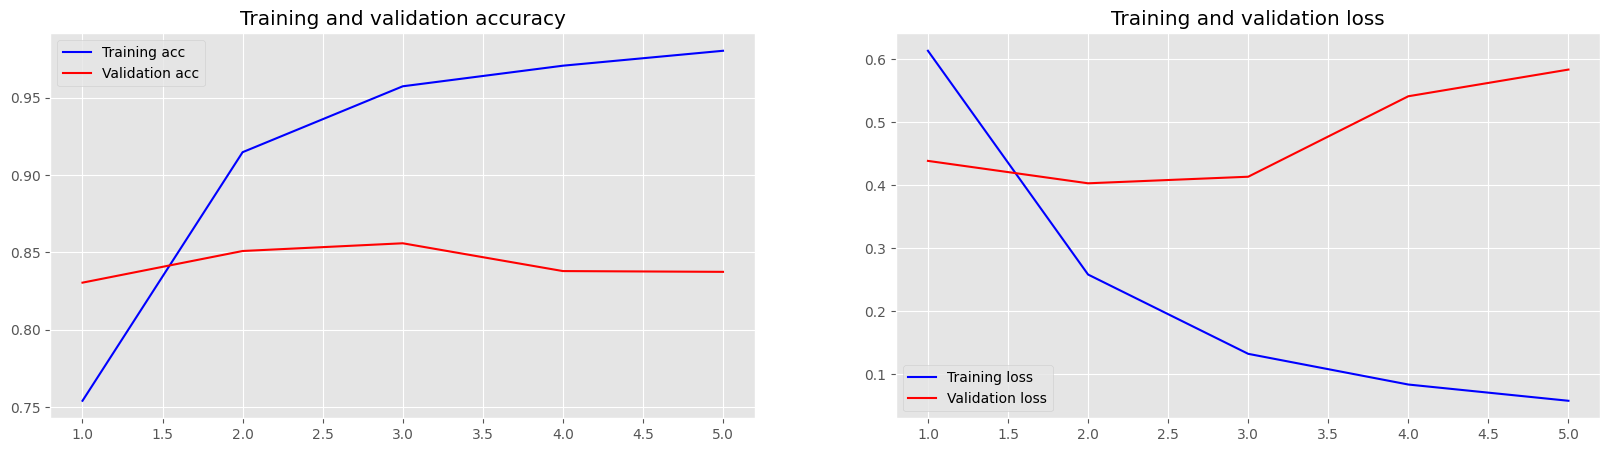

In [25]:
# Visualize the data 
# history.history to see the history of the deep learning model like accuracy and lose 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [26]:
#save the model
model.save('model_pas.h5')
print("Model has created!")

Model has created!


In [38]:
input_text = """
kamu JELEK sekali  """

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

# def analysis(text):

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model_pas.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Text: %s" % text[0])
print("Sentiment: %s" % sentiment[polarity])

1/1 [==============================] - 0s 228ms/step
Text:  kamu jelek sekali  
Sentiment: negative
